# From Detection to Credibility: A Machine Learning Framework for Assessing News Source Reliability



In [1]:
# Import necessary libraries

# Data manipulation
import pandas as pd
import numpy as np

# Statistical functions
from scipy.stats import zscore

# For concurrency (running functions in parallel)
from concurrent.futures import ThreadPoolExecutor

# For caching (to speed up repeated function calls)
from functools import lru_cache

# For progress tracking
from tqdm import tqdm

# Plotting and Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Language Detection packages
# `langdetect` for detecting language
from langdetect import detect as langdetect_detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
# `langid` for an alternative language detection method
from langid import classify as langid_classify

# Text Preprocessing and NLP
# Stopwords (common words to ignore) from NLTK
from nltk.corpus import stopwords
# Tokenizing sentences/words
from nltk.tokenize import word_tokenize
# Part-of-speech tagging
from nltk import pos_tag
# Lemmatization (converting words to their base form)
from nltk.stem import WordNetLemmatizer
import nltk
# Regular expressions for text pattern matching
import re

# Word Cloud generation
from wordcloud import WordCloud

In [2]:
data = pd.read_csv('../processed_data.csv')

In [3]:
data

,label,full_content,processed_full_content
0,1,No comment is expected from Barack Obama Membe...,no comment expect barack obama member fyf911 f...
1,1,Did they post their votes for Hillary already?,post vote hillari alreadi
2,1,"Now, most of the demonstrators gathered last n...",demonstr gather last night exercis constitut p...
3,0,A dozen politically active pastors came here f...,dozen polit activ pastor came privat dinner fr...
4,1,"The RS-28 Sarmat missile, dubbed Satan 2, will...",rs-28 sarmat missil dub satan 2 replac ss-18 f...
...,...,...,...
63855,0,WASHINGTON (Reuters) - Hackers believed to be ...,washington reuter hacker believ work russian g...
63856,1,"You know, because in fantasyland Republicans n...",know fantasyland republican never question cit...
63857,0,Migrants Refuse To Leave Train At Refugee Camp...,migrant refus leav train refuge camp hungari t...
63858,0,MEXICO CITY (Reuters) - Donald Trump’s combati...,mexico citi reuter donald trump ’ comb style b...


# Basic RNN

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
import numpy as np
import random

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Parameters
vocab_size = 5000         # Limit vocabulary to 5000 words
embedding_dim = 128       # Embedding dimensions for each word
max_sequence_length = 300 # Max number of words in each sequence
l2_lambda = 0.01          # L2 regularization factor

# Step 1: Tokenize and Pad the Text
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data['processed_full_content'])
sequences = tokenizer.texts_to_sequences(data['processed_full_content'])
X_padded = pad_sequences(sequences, maxlen=max_sequence_length)

# Labels
y = data['label'].values

# Step 2: Define a function to create a Simple RNN Model with L2 Regularization
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length, trainable=True))
    model.add(SimpleRNN(64, activation='tanh', kernel_regularizer=l2(l2_lambda)))
    model.add(Dropout(0.3))  # Add dropout for regularization
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_lambda)))  # Output layer for binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)

# Step 3: Perform Stratified K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], []

for train_index, test_index in kf.split(X_padded, y):
    X_train, X_test = X_padded[train_index], X_padded[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    with tf.device('/CPU:0'):
        model = create_model()  # Create a new instance for each fold
    
        # Train the model with Early Stopping
        model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2, 
                  verbose=1, callbacks=[early_stopping])
    
    # Evaluate the model
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # Append metrics for each fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Print average performance metrics across folds
print('Cross-Validation Performance Metrics:')
print(f'Average Accuracy: {np.mean(accuracy_scores):.4f}')
print(f'Average Precision: {np.mean(precision_scores):.4f}')
print(f'Average Recall: {np.mean(recall_scores):.4f}')
print(f'Average F1 Score: {np.mean(f1_scores):.4f}')


Epoch 1/10
320/320 [==============================] - 31s 94ms/step - loss: 0.5280 - accuracy: 0.8878 - val_loss: 0.2330 - val_accuracy: 0.9500
Epoch 2/10
320/320 [==============================] - 32s 100ms/step - loss: 0.1893 - accuracy: 0.9561 - val_loss: 0.1844 - val_accuracy: 0.9529
Epoch 3/10
320/320 [==============================] - 33s 102ms/step - loss: 0.1729 - accuracy: 0.9596 - val_loss: 0.2662 - val_accuracy: 0.9195
Epoch 4/10
320/320 [==============================] - 33s 104ms/step - loss: 0.1417 - accuracy: 0.9687 - val_loss: 0.1669 - val_accuracy: 0.9575
Epoch 5/10
320/320 [==============================] - 33s 104ms/step - loss: 0.1738 - accuracy: 0.9590 - val_loss: 0.1844 - val_accuracy: 0.9493
Epoch 6/10
320/320 [==============================] - 34s 105ms/step - loss: 0.1301 - accuracy: 0.9712 - val_loss: 0.1668 - val_accuracy: 0.9591
Epoch 7/10
320/320 [==============================] - 32s 101ms/step - loss: 0.1937 - accuracy: 0.9544 - val_loss: 0.2574 - val_acc

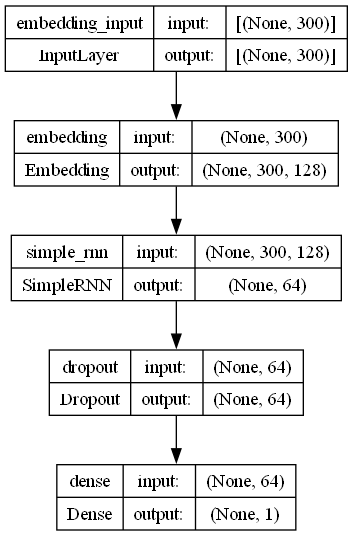

In [8]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Basic RNN + Pre Truncation

Truncation ensures that each sequences has a uniform length of `max_sequence_length` which prevents excessively long sequences and thus preventing slow training and inference time.

Truncating from the end (`truncating='pre'`) removes words from the beginning of each sequence.

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
import numpy as np
import random

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Parameters
vocab_size = 5000         # Limit vocabulary to 5000 words
embedding_dim = 128        # Embedding dimensions for each word
max_sequence_length = 300 # Max number of words in each sequence

# Step 1: Tokenize and Pad the Text
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data['processed_full_content'])
sequences = tokenizer.texts_to_sequences(data['processed_full_content'])
X_padded = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='pre')

# Labels
y = data['label'].values

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Step 2: Define a Simple RNN Model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length, trainable=True))
model.add(SimpleRNN(64, activation='tanh'))
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(1, activation='sigmoid'))   # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 3: Train the Model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

# Step 4: Evaluate the Model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate and print metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print('Performance Metrics:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Epoch 1/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - accuracy: 0.5951 - loss: 0.6290 - val_accuracy: 0.6311 - val_loss: 0.5309
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.6626 - loss: 0.5196 - val_accuracy: 0.7095 - val_loss: 0.5456
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.7218 - loss: 0.5205 - val_accuracy: 0.8323 - val_loss: 0.4148
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.8430 - loss: 0.3806 - val_accuracy: 0.8270 - val_loss: 0.4416
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.8123 - loss: 0.4306 - val_accuracy: 0.7518 - val_loss: 0.5181
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.8503 - loss: 0.3740 - val_accuracy: 0.8603 - val_loss: 0.3842
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.8976 - loss: 0.2948 - val_accuracy: 0.7833 - val_loss: 0.5079
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.7295 - loss: 0.4956 - 

# Basic RNN + Post Truncation

Truncating from the end (`truncating='post'`) keeps the beginning of each sequence.

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
import numpy as np
import random

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Parameters
vocab_size = 5000         # Limit vocabulary to 5000 words
embedding_dim = 128        # Embedding dimensions for each word
max_sequence_length = 300 # Max number of words in each sequence

# Step 1: Tokenize and Pad the Text
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data['processed_full_content'])
sequences = tokenizer.texts_to_sequences(data['processed_full_content'])
X_padded = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Labels
y = data['label'].values

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Step 2: Define a Simple RNN Model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length, trainable=True))
model.add(SimpleRNN(64, activation='tanh'))
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(1, activation='sigmoid'))   # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 3: Train the Model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

# Step 4: Evaluate the Model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate and print metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print('Performance Metrics:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Epoch 1/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


639/639 ━━━━━━━━━━━━━━━━━━━━ 43s 65ms/step - accuracy: 0.6082 - loss: 0.6432 - val_accuracy: 0.8627 - val_loss: 0.3881
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 42s 65ms/step - accuracy: 0.7230 - loss: 0.5570 - val_accuracy: 0.6179 - val_loss: 0.6430
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 43s 67ms/step - accuracy: 0.5851 - loss: 0.6729 - val_accuracy: 0.7195 - val_loss: 0.5757
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 43s 67ms/step - accuracy: 0.7255 - loss: 0.5720 - val_accuracy: 0.7161 - val_loss: 0.5743
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 43s 67ms/step - accuracy: 0.7338 - loss: 0.5618 - val_accuracy: 0.7328 - val_loss: 0.5621
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.6807 - loss: 0.6032 - val_accuracy: 0.5873 - val_loss: 0.6696
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.6110 - loss: 0.6592 - val_accuracy: 0.6228 - val_loss: 0.6467
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.6431 - loss: 0.6243 - val_accurac

# RNN + Head-Tail Truncation

This method combines the beginning and the end of each sequence, keeping the first and last parts of the sequence and discarding the middle.

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
import numpy as np
import random

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Parameters
vocab_size = 5000         # Limit vocabulary to 5000 words
embedding_dim = 128        # Embedding dimensions for each word
max_sequence_length = 300 # Max number of words in each sequence

def head_tail_truncate(sequence, max_len=400):
    half_len = max_len // 2
    if len(sequence) <= max_len:
        return sequence
    return sequence[:half_len] + sequence[-half_len:]

# Step 1: Tokenize and Pad the Text
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data['processed_full_content'])
sequences = tokenizer.texts_to_sequences(data['processed_full_content'])
truncated_sequences = [head_tail_truncate(seq) for seq in sequences]
X_padded = pad_sequences(truncated_sequences, maxlen=max_sequence_length, padding='post')

# Labels
y = data['label'].values

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Step 2: Define a Simple RNN Model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length, trainable=True))
model.add(SimpleRNN(64, activation='tanh'))
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(1, activation='sigmoid'))   # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 3: Train the Model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

# Step 4: Evaluate the Model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate and print metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print('Performance Metrics:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Epoch 1/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.5860 - loss: 0.6449 - val_accuracy: 0.6028 - val_loss: 0.5874
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.6041 - loss: 0.6117 - val_accuracy: 0.6397 - val_loss: 0.5697
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.6466 - loss: 0.5433 - val_accuracy: 0.6202 - val_loss: 0.5471
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.6540 - loss: 0.5237 - val_accuracy: 0.6088 - val_loss: 0.6058
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.5906 - loss: 0.6375 - val_accuracy: 0.6085 - val_loss: 0.6014
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.6133 - loss: 0.6073 - val_accuracy: 0.6490 - val_loss: 0.5749
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.6340 - loss: 0.5826 - val_accuracy: 0.6412 - val_loss: 0.5547
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.6517 - loss: 0.5541 - 

# RNN + Middle Truncation

This method keeps the middle part of the sequence.

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
import numpy as np
import random

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Parameters
vocab_size = 5000         # Limit vocabulary to 5000 words
embedding_dim = 128        # Embedding dimensions for each word
max_sequence_length = 200 # Max number of words in each sequence

def middle_truncate(sequence, max_len=200):
    if len(sequence) <= max_len:
        return sequence  # No truncation if sequence is already within the limit
    
    # Calculate the starting point to extract the middle
    start_index = (len(sequence) - max_len) // 2
    return sequence[start_index:start_index + max_len]

# Step 1: Tokenize and Pad the Text
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data['processed_full_content'])
sequences = tokenizer.texts_to_sequences(data['processed_full_content'])
truncated_sequences = [middle_truncate(seq) for seq in sequences]
X_padded = pad_sequences(truncated_sequences, maxlen=max_sequence_length, padding='post')

# Labels
y = data['label'].values

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Step 2: Define a Simple RNN Model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length, trainable=True))
model.add(SimpleRNN(64, activation='tanh'))
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(1, activation='sigmoid'))   # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 3: Train the Model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

# Step 4: Evaluate the Model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate and print metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print('Performance Metrics:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Epoch 1/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


639/639 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.6777 - loss: 0.6054 - val_accuracy: 0.5757 - val_loss: 0.6667
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.6110 - loss: 0.6465 - val_accuracy: 0.6436 - val_loss: 0.6298
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.6759 - loss: 0.6267 - val_accuracy: 0.7233 - val_loss: 0.5544
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.7243 - loss: 0.5567 - val_accuracy: 0.8395 - val_loss: 0.4472
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.7033 - loss: 0.5778 - val_accuracy: 0.6869 - val_loss: 0.5805
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.7114 - loss: 0.5442 - val_accuracy: 0.7272 - val_loss: 0.5188
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.7420 - loss: 0.5447 - val_accuracy: 0.7415 - val_loss: 0.5394
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.7473 - loss: 0.5295 - val_accurac

# RNN + Count Vectoriser

### Loss of Sequential Information
Poor performance because RNNs are not well-suited to the bag-of-words representation generated by `CountVectorizer`. Since `CountVectorizer` treats each document as a set of words without any order, words are represented only by their counts, not by their position in the text. Since RNNs are designed to work with ordered sequences, where the position and context of words matter, without preserving word order, the RNN cannot capture dependencies between words over time.

### Sparse, non-contextual input
`CountVectorizer` produces a sparse representation where each word is treated as an independent feature based on its frequency. There is no semantic or contextual relationship between words, and the word counts lack dense, meaningful relationships that an RNN could leverage, since RNNs perform best with dense, continuous data that represents meaningful relationships between words, typically achieved with word embeddings.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
import numpy as np
import random

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Parameters
max_features = 5000       # Limit vocabulary to 5000 words
max_sequence_length = 300 # Max number of words in each sequence

# Step 1: Text Vectorization using CountVectorizer
vectorizer = CountVectorizer(max_features=max_features)
X_counts = vectorizer.fit_transform(data['processed_full_content']).toarray()

# Convert Counts to Sequences
# In this case, we're treating each word count as a sequence "step," although this is not a true sequence.
# To match the expected input format, we use padding.
X_padded = pad_sequences(X_counts, maxlen=max_sequence_length)

# Labels
y = data['label'].values

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Reshape input to 3D for RNN (samples, timesteps, features)
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Step 2: Define a Simple RNN Model (without Embedding layer)
model = Sequential()
model.add(SimpleRNN(64, activation='tanh', input_shape=(X_train_reshaped.shape[1], 1)))  # Input shape adjusted
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 3: Train the Model
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

# Step 4: Evaluate the Model
y_pred_prob = model.predict(X_test_reshaped)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate and print metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print('Performance Metrics:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.5829 - loss: 0.6673 - val_accuracy: 0.6391 - val_loss: 0.6299
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.6016 - loss: 0.6598 - val_accuracy: 0.5697 - val_loss: 0.6825
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.5183 - loss: 0.7002 - val_accuracy: 0.5404 - val_loss: 0.6866
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.5322 - loss: 0.6917 - val_accuracy: 0.5410 - val_loss: 0.6917
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.5402 - loss: 0.6905 - val_accuracy: 0.5410 - val_loss: 0.6949
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.5371 - loss: 0.6901 - val_accuracy: 0.5410 - val_loss: 0.6889
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.5409 - loss: 0.6902 - val_accuracy: 0.5410 - val_loss: 0.6845
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.5382 - loss: 0.6896 - 

# RNN + Count Vectoriser + Conversion to pseudo-sequences with word indices

Performance is poorer than Basic RNN.

Over here, we transform the `CountVectorizer` output into integer sequences which is compatible with the embedding layer. Unlike `Tokenizer` which retains the natural order or words in the text, converting each word to an index that aligns with its position in the original sentence, `CountVectorizer` converts into pseudo-sequences which loses the actual word order. This means that the RNN may miss out on valuable sequential information.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
import numpy as np
import random

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Parameters
MAX_FEATURES = 5000       # Number of words to consider as features
EMBEDDING_DIM = 128       # Dimensionality of the embedding vectors
MAX_SEQUENCE_LENGTH = 300 # Max number of words in a sequence
l2_lambda = 0.01          # L2 regularization factor

# Step 1: Text Vectorization using CountVectorizer
vectorizer = CountVectorizer(max_features=MAX_FEATURES)
X_counts = vectorizer.fit_transform(data['processed_full_content'])
word_index = vectorizer.vocabulary_

# Inverse vocabulary mapping for sequences creation
index_to_word = {i: word for word, i in word_index.items()}

def counts_to_sequences(X_counts):
    sequences = []
    for i in range(X_counts.shape[0]):
        indices = X_counts[i].nonzero()[1]
        words = [index_to_word[idx] for idx in indices]
        seq = [word_index[word] + 1 for word in words]  # +1 because 0 is reserved for padding
        sequences.append(seq)
    return sequences

sequences = counts_to_sequences(X_counts)
X_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Labels
y = data['label'].values

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)

# Initialize lists to store metrics for each run
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Perform 5 runs to get average metrics
for i in range(5):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=seed + i)

    # Use CPU explicitly for model creation and training
    with tf.device('/CPU:0'):
        # Step 2: Define the RNN Model with L2 Regularization and Early Stopping
        model = Sequential()
        model.add(Embedding(input_dim=len(word_index) + 1, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, trainable=True))
        model.add(SimpleRNN(64, activation='tanh', kernel_regularizer=l2(l2_lambda)))
        model.add(Dropout(0.5))  # Add dropout for regularization
        model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_lambda)))

        # Compile the model
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Train the model with Early Stopping
        model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1, callbacks=[early_stopping])

    # Predictions and Evaluation
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Calculate and store metrics
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred, zero_division=0))
    recall_scores.append(recall_score(y_test, y_pred, zero_division=0))
    f1_scores.append(f1_score(y_test, y_pred, zero_division=0))

# Calculate average metrics
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)

# Print performance metrics
print('Average Performance Metrics over 5 runs:')
print(f'Average Accuracy: {avg_accuracy:.4f}')
print(f'Average Precision: {avg_precision:.4f}')
print(f'Average Recall: {avg_recall:.4f}')
print(f'Average F1 Score: {avg_f1:.4f}')


Epoch 1/10
639/639 [==============================] - 50s 76ms/step - loss: 0.5551 - accuracy: 0.8619 - val_loss: 0.3746 - val_accuracy: 0.8817
Epoch 2/10
639/639 [==============================] - 42s 65ms/step - loss: 0.3904 - accuracy: 0.8847 - val_loss: 0.3048 - val_accuracy: 0.9164
Epoch 3/10
639/639 [==============================] - 41s 65ms/step - loss: 0.6195 - accuracy: 0.6920 - val_loss: 0.6565 - val_accuracy: 0.7116
Epoch 4/10
639/639 [==============================] - 43s 67ms/step - loss: 0.4954 - accuracy: 0.7888 - val_loss: 0.5109 - val_accuracy: 0.8338
Epoch 5/10
639/639 [==============================] - 43s 68ms/step - loss: 0.3115 - accuracy: 0.9022 - val_loss: 0.2575 - val_accuracy: 0.9147
Epoch 6/10
639/639 [==============================] - 42s 65ms/step - loss: 0.3060 - accuracy: 0.9017 - val_loss: 0.2638 - val_accuracy: 0.9164
Epoch 7/10
639/639 [==============================] - 42s 65ms/step - loss: 0.6019 - accuracy: 0.7205 - val_loss: 0.4595 - val_accuracy:

# RNN + Word2vec

We would expect Word2Vec to perform better even though Word2Vec embeddings are generally more informative since training Word2Vec on our data ensures the embeddings are more relevant to our specific dataset.

### Pre-trained semantic relationships
Word2Vec learns word relationships based on context by training on large corpora, so even if specific words are rare or do not appear frequently in our dataset, their embeddings can still capture semantic meaning.

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from gensim.models import Word2Vec
import tensorflow as tf
import numpy as np
import random

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Parameters
vocab_size = 5000         # Limit vocabulary to 5000 words
embedding_dim = 128        # Embedding dimensions for each word
max_sequence_length = 300  # Max number of words in each sequence

# Step 1: Tokenize the Text Data
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data['processed_full_content'])
sequences = tokenizer.texts_to_sequences(data['processed_full_content'])
X_padded = pad_sequences(sequences, maxlen=max_sequence_length)

# Labels
y = data['label'].values

# Step 2: Prepare Sentences for Word2Vec Training
# Convert tokenized sequences to lists of words for Word2Vec
sentences = [text.split() for text in data['processed_full_content']]

# Step 3: Train a Word2Vec Model
word2vec_model = Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4, sg=1)
# Note: sg=1 uses skip-gram, which is effective for smaller datasets

# Step 4: Create Embedding Matrix from Trained Word2Vec Model
embedding_matrix = np.zeros((vocab_size, embedding_dim))
word_index = tokenizer.word_index

for word, i in word_index.items():
    if i < vocab_size:
        # Retrieve the embedding vector for the word
        embedding_vector = word2vec_model.wv[word] if word in word2vec_model.wv else None
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Step 6: Define the RNN Model with Word2Vec Embeddings
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
                    input_length=max_sequence_length, trainable=True))  # Use trainable=False if no fine-tuning is needed
model.add(SimpleRNN(64, activation='tanh'))
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 7: Train the Model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

# Step 8: Evaluate the Model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate and print metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print('Performance Metrics:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Epoch 1/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


639/639 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - accuracy: 0.8433 - loss: 0.3571 - val_accuracy: 0.9400 - val_loss: 0.1690
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.9341 - loss: 0.1955 - val_accuracy: 0.9483 - val_loss: 0.1478
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.9526 - loss: 0.1471 - val_accuracy: 0.9451 - val_loss: 0.1610
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.9565 - loss: 0.1344 - val_accuracy: 0.9413 - val_loss: 0.1732
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.9419 - loss: 0.1612 - val_accuracy: 0.9167 - val_loss: 0.2163
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.9644 - loss: 0.1115 - val_accuracy: 0.9464 - val_loss: 0.1762
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.9671 - loss: 0.1012 - val_accuracy: 0.9444 - val_loss: 0.1805
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step - accuracy: 0.9703 - loss: 0.0929 - val_accurac

# RNN + Word2vec + Stratified K-fold Cross Validation

We use Stratified K-fold Cross-Validation here to ensure that each fold in our cross-validation process has the same proportion of classes as the entire dataset. This gives a more reliable measure of model performance across different data splits. It prevents the model from performing well on some folds and poorly on others due to class imbalance, offering a fair assessment of the model's generalisation ability.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from gensim.models import Word2Vec
import tensorflow as tf
import numpy as np
import random

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Parameters
vocab_size = 5000         # Limit vocabulary to 5000 words
embedding_dim = 128       # Embedding dimensions for each word
max_sequence_length = 300 # Max number of words in each sequence
l2_lambda = 0.01          # L2 regularization factor

# Step 1: Tokenize the Text Data
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data['processed_full_content'])
sequences = tokenizer.texts_to_sequences(data['processed_full_content'])
X_padded = pad_sequences(sequences, maxlen=max_sequence_length)

# Labels
y = data['label'].values

# Step 2: Prepare Sentences for Word2Vec Training
# Convert tokenized sequences to lists of words for Word2Vec
sentences = [text.split() for text in data['processed_full_content']]

# Step 3: Train a Word2Vec Model
word2vec_model = Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4, sg=1)

# Step 4: Create Embedding Matrix from Trained Word2Vec Model
embedding_matrix = np.zeros((vocab_size, embedding_dim))
word_index = tokenizer.word_index

for word, i in word_index.items():
    if i < vocab_size:
        # Retrieve the embedding vector for the word
        embedding_vector = word2vec_model.wv[word] if word in word2vec_model.wv else None
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)

# Initialize lists to store metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Step 5: Stratified 5-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X_padded, y):
    X_train, X_test = X_padded[train_index], X_padded[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Force CPU for model creation and training
    with tf.device('/CPU:0'):
        # Step 6: Define the RNN Model with L2 Regularization
        model = Sequential()
        model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
                            input_length=max_sequence_length, trainable=True))
        model.add(SimpleRNN(64, activation='tanh', kernel_regularizer=l2(l2_lambda)))
        model.add(Dropout(0.5))  # Add dropout for regularization
        model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_lambda)))  # Output layer for binary classification

        # Compile the model
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Step 7: Train the Model with Early Stopping
        model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1, callbacks=[early_stopping])

    # Step 8: Evaluate the Model
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Calculate and store metrics for each fold
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred, zero_division=0))
    recall_scores.append(recall_score(y_test, y_pred, zero_division=0))
    f1_scores.append(f1_score(y_test, y_pred, zero_division=0))

# Calculate average metrics across all folds
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)

# Print average performance metrics
print('Stratified 5-Fold Cross-Validation Average Performance Metrics:')
print(f'Average Accuracy: {avg_accuracy:.4f}')
print(f'Average Precision: {avg_precision:.4f}')
print(f'Average Recall: {avg_recall:.4f}')
print(f'Average F1 Score: {avg_f1:.4f}')

Epoch 1/10
639/639 [==============================] - 39s 60ms/step - loss: 0.6627 - accuracy: 0.8959 - val_loss: 0.3527 - val_accuracy: 0.9395
Epoch 2/10
639/639 [==============================] - 38s 59ms/step - loss: 0.3129 - accuracy: 0.9379 - val_loss: 0.3066 - val_accuracy: 0.9249
Epoch 3/10
639/639 [==============================] - 38s 59ms/step - loss: 0.3072 - accuracy: 0.9091 - val_loss: 0.5402 - val_accuracy: 0.8001
Epoch 4/10
639/639 [==============================] - 38s 59ms/step - loss: 0.3650 - accuracy: 0.9055 - val_loss: 0.2694 - val_accuracy: 0.9454
Epoch 5/10
639/639 [==============================] - 38s 60ms/step - loss: 0.2448 - accuracy: 0.9491 - val_loss: 0.2197 - val_accuracy: 0.9509
Epoch 6/10
639/639 [==============================] - 38s 59ms/step - loss: 0.2616 - accuracy: 0.9353 - val_loss: 0.2336 - val_accuracy: 0.9494
Epoch 7/10
639/639 [==============================] - 38s 59ms/step - loss: 0.2022 - accuracy: 0.9544 - val_loss: 0.2167 - val_accuracy:

# RNN + Hashing Vectorizer

Reason why performance is so poor is because `HashingVectorizer` generates fixed-size representations by hashing words, which can cause collisions (different words mapping to the same hash value). This is result in similar representations for distinct words, reducing the RNN's ability to distinguish important terms.

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
import numpy as np
import random

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Parameters
vocab_size = 5000          # Limit vocabulary to 5000 hash bins (each bin for each word hash)
embedding_dim = 128        # Embedding dimensions for each word
max_sequence_length = 300  # Max number of words in each sequence

# Step 1: Vectorize Text Data Using HashingVectorizer
vectorizer = HashingVectorizer(n_features=vocab_size, alternate_sign=False)
X_hashed = vectorizer.transform(data['processed_full_content'])

# Convert the sparse hashed matrix to a dense matrix and pad sequences
X_padded = pad_sequences(X_hashed.toarray(), maxlen=max_sequence_length)

# Labels
y = data['label'].values

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Step 3: Define the RNN Model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(SimpleRNN(64, activation='tanh'))
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 4: Train the Model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

# Step 5: Evaluate the Model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate and print metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print('Performance Metrics:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Epoch 1/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


639/639 ━━━━━━━━━━━━━━━━━━━━ 45s 68ms/step - accuracy: 0.5133 - loss: 0.7102 - val_accuracy: 0.5410 - val_loss: 0.6914
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 43s 67ms/step - accuracy: 0.5342 - loss: 0.6933 - val_accuracy: 0.5410 - val_loss: 0.6901
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 44s 69ms/step - accuracy: 0.5443 - loss: 0.6895 - val_accuracy: 0.5410 - val_loss: 0.6900
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 44s 69ms/step - accuracy: 0.5442 - loss: 0.6898 - val_accuracy: 0.5410 - val_loss: 0.6899
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 45s 70ms/step - accuracy: 0.5443 - loss: 0.6895 - val_accuracy: 0.5410 - val_loss: 0.6899
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 44s 69ms/step - accuracy: 0.5367 - loss: 0.6933 - val_accuracy: 0.5410 - val_loss: 0.6913
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 46s 72ms/step - accuracy: 0.5363 - loss: 0.6913 - val_accuracy: 0.5410 - val_loss: 0.6902
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 45s 71ms/step - accuracy: 0.5436 - loss: 0.6897 - val_accurac

# RNN + GloVe (Global Vectors for Word Representation)

GloVe is a popular pre-trained word embedding model, used to represent words as vectors, where distances and directions among vectors capture semantic relationships.

Unlike `Word2Vec`, which are based solely on local context (words in a sliding window), GloVe embeddings combine global statistical information from the entire corpus with local context, making them effective at capturing word meaning.

GloVe build a matrix where each cell represents the number of times two words appear together in a large corpus. It calculates word embeddings by learning from this co-occurence information, capturing the idea that words with similar meanings often appear in similar contexts.

`glove.6B.100d.txt` is 100-dimensional embeddings trained on a 6 billion word corpus.

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
import numpy as np
import random

# Set random seed for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Parameters
vocab_size = 5000         # Limit vocabulary to 5000 words
embedding_dim = 100        # Dimension of GloVe embeddings
max_sequence_length = 300  # Max number of words in each sequence

# Load GloVe Embeddings
embedding_index = {}
glove_file_path = 'glove.6B.100d.txt'  # Update path to your GloVe file if necessary
with open(glove_file_path, 'r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

# Step 1: Tokenize the Text Data
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data['processed_full_content'])
sequences = tokenizer.texts_to_sequences(data['processed_full_content'])
X_padded = pad_sequences(sequences, maxlen=max_sequence_length)

# Labels
y = data['label'].values

# Step 2: Create Embedding Matrix from GloVe Embeddings
embedding_matrix = np.zeros((vocab_size, embedding_dim))
word_index = tokenizer.word_index

for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Step 4: Define and Compile the RNN Model with GloVe Embeddings
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
                    input_length=max_sequence_length, trainable=True))
model.add(SimpleRNN(64, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 5: Train the Model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

# Step 6: Evaluate the Model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate and print metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print('Performance Metrics:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Epoch 1/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


639/639 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - accuracy: 0.7940 - loss: 0.4351 - val_accuracy: 0.9145 - val_loss: 0.2299
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 33s 51ms/step - accuracy: 0.9255 - loss: 0.2104 - val_accuracy: 0.9442 - val_loss: 0.1562
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - accuracy: 0.9431 - loss: 0.1674 - val_accuracy: 0.9155 - val_loss: 0.2299
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 34s 53ms/step - accuracy: 0.9531 - loss: 0.1465 - val_accuracy: 0.9451 - val_loss: 0.1536
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - accuracy: 0.9622 - loss: 0.1182 - val_accuracy: 0.9445 - val_loss: 0.1601
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - accuracy: 0.9640 - loss: 0.1090 - val_accuracy: 0.9513 - val_loss: 0.1588
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 34s 53ms/step - accuracy: 0.9741 - loss: 0.0847 - val_accuracy: 0.9509 - val_loss: 0.1734
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - accuracy: 0.9699 - loss: 0.0917 - val_accurac

# RNN + GloVe + Stratified K-fold Cross Validation

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
import numpy as np
import random

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Parameters
vocab_size = 5000         # Limit vocabulary to 5000 words
embedding_dim = 100        # Dimension of GloVe embeddings
max_sequence_length = 300  # Max number of words in each sequence
n_splits = 5               # Number of folds

# Load GloVe Embeddings
embedding_index = {}
glove_file_path = 'glove.6B.100d.txt'  # Update path to your GloVe file if necessary
with open(glove_file_path, 'r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

# Step 1: Tokenize the Text Data
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data['processed_full_content'])
sequences = tokenizer.texts_to_sequences(data['processed_full_content'])
X_padded = pad_sequences(sequences, maxlen=max_sequence_length)

# Labels
y = data['label'].values

# Step 2: Create Embedding Matrix from GloVe Embeddings
embedding_matrix = np.zeros((vocab_size, embedding_dim))
word_index = tokenizer.word_index

for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Step 3: Stratified K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], []

for fold, (train_index, test_index) in enumerate(kf.split(X_padded, y), 1):
    print(f"Fold {fold}")
    
    # Split data into train and test for this fold
    X_train, X_test = X_padded[train_index], X_padded[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Step 4: Define and Compile the RNN Model with GloVe Embeddings
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
                        input_length=max_sequence_length, trainable=True))
    model.add(SimpleRNN(64, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Step 5: Train the Model
    model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)
    
    # Step 6: Evaluate the Model
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Calculate metrics for this fold
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    
    print(f"Fold {fold} Metrics:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Step 7: Average Metrics Across All Folds
print("\nAverage Performance Metrics across all folds:")
print(f"Accuracy: {np.mean(accuracy_scores):.4f}")
print(f"Precision: {np.mean(precision_scores):.4f}")
print(f"Recall: {np.mean(recall_scores):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f}")

Fold 1
Epoch 1/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


639/639 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.7960 - loss: 0.4314 - val_accuracy: 0.9329 - val_loss: 0.2092
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.9109 - loss: 0.2403 - val_accuracy: 0.9269 - val_loss: 0.2267
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.9417 - loss: 0.1760 - val_accuracy: 0.9419 - val_loss: 0.1768
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.9457 - loss: 0.1628 - val_accuracy: 0.9433 - val_loss: 0.1777
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.9633 - loss: 0.1170 - val_accuracy: 0.9446 - val_loss: 0.1726
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.9695 - loss: 0.0990 - val_accuracy: 0.9404 - val_loss: 0.1904
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.9679 - loss: 0.0996 - val_accuracy: 0.9300 - val_loss: 0.2160
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.9598 - loss: 0.1206 - val_accurac

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


639/639 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.8015 - loss: 0.4180 - val_accuracy: 0.9341 - val_loss: 0.1882
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.9323 - loss: 0.1953 - val_accuracy: 0.9391 - val_loss: 0.1732
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.9456 - loss: 0.1640 - val_accuracy: 0.9468 - val_loss: 0.1539
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.9364 - loss: 0.1727 - val_accuracy: 0.9459 - val_loss: 0.1583
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.9651 - loss: 0.1125 - val_accuracy: 0.9415 - val_loss: 0.1782
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.9644 - loss: 0.1096 - val_accuracy: 0.9369 - val_loss: 0.1802
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step - accuracy: 0.9192 - loss: 0.2196 - val_accuracy: 0.9066 - val_loss: 0.2359
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step - accuracy: 0.9298 - loss: 0.2008 - val_accurac

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


639/639 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step - accuracy: 0.7977 - loss: 0.4287 - val_accuracy: 0.9199 - val_loss: 0.2123
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.9184 - loss: 0.2264 - val_accuracy: 0.9405 - val_loss: 0.1729
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.9415 - loss: 0.1754 - val_accuracy: 0.7600 - val_loss: 0.5444
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.9091 - loss: 0.2333 - val_accuracy: 0.9476 - val_loss: 0.1608
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.9539 - loss: 0.1429 - val_accuracy: 0.9502 - val_loss: 0.1695
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.9656 - loss: 0.1080 - val_accuracy: 0.9465 - val_loss: 0.1748
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.9699 - loss: 0.0950 - val_accuracy: 0.9045 - val_loss: 0.2368
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - accuracy: 0.9440 - loss: 0.1673 - val_accurac

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


639/639 ━━━━━━━━━━━━━━━━━━━━ 29s 43ms/step - accuracy: 0.7951 - loss: 0.4262 - val_accuracy: 0.8459 - val_loss: 0.3497
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.9078 - loss: 0.2448 - val_accuracy: 0.7466 - val_loss: 0.4985
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.8129 - loss: 0.3948 - val_accuracy: 0.7436 - val_loss: 0.5362
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.8403 - loss: 0.3710 - val_accuracy: 0.9070 - val_loss: 0.2493
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.8771 - loss: 0.3016 - val_accuracy: 0.7453 - val_loss: 0.5051
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.7180 - loss: 0.5146 - val_accuracy: 0.7757 - val_loss: 0.4521
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.7736 - loss: 0.4542 - val_accuracy: 0.8210 - val_loss: 0.3836
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.8326 - loss: 0.3815 - val_accurac

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


639/639 ━━━━━━━━━━━━━━━━━━━━ 29s 43ms/step - accuracy: 0.7914 - loss: 0.4375 - val_accuracy: 0.9190 - val_loss: 0.2262
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - accuracy: 0.9111 - loss: 0.2488 - val_accuracy: 0.9315 - val_loss: 0.1994
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - accuracy: 0.9412 - loss: 0.1742 - val_accuracy: 0.9470 - val_loss: 0.1591
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.9509 - loss: 0.1483 - val_accuracy: 0.9493 - val_loss: 0.1568
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.9403 - loss: 0.1629 - val_accuracy: 0.9464 - val_loss: 0.1657
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - accuracy: 0.9402 - loss: 0.1656 - val_accuracy: 0.9486 - val_loss: 0.1639
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.9649 - loss: 0.1138 - val_accuracy: 0.9484 - val_loss: 0.1626
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.9726 - loss: 0.0902 - val_accurac

# RNN + GloVe + Stratified K-fold Cross Validation + L2 Regularization (Ridge)

### L1 vs. L2 Regularization:
- L1 Regularization (Lasso): Adds the absolute value of the weight to the loss function, resulting in sparse weights (some weights become exactly 0).
    - Effect: Tends to create sparse models by driving some weights to zero, effectively performing feature selection.
- L2 Regularization (Ridge): Adds the squared value of the weights to the loss function, penalizing large weights withough driving them to 0.
    - Effect: Tends to distribute the penalty across all weights, resulting in smaller but non-zero weights.

Why L2 is preferred is because L2 penalises large weights but allows them to remain small rather than zeroing them out which is useful in RNNs where all the weights contribute to the learning process.

On the other hand, L1 forces some weights to become exactly 0, effectively performing feature selection by eliminating certain weights entirely which can disrupt sequential learning in RNNs where continuous, context-dependent features are essential.

Also, RNNs are more stable with L2 because it reduces weight magnitudes evely, which helps with gradient stability across time steps, which is particularly important in sequential tasks where large gradients can destabilise training. L1 can create sparse weights, potentially leading to instability if certain pathways are zeroed out, which can affect sequential dependencies.

L1 is more useful for feature selection in high-dimensional data where many features are irrelevant. Also L1's ability to zero out weights can make models more interpretable, as it helps identify which features are mots influential in classification, which is more common in sparse models like log regression, where interpretability of individual features is more practical.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
import numpy as np
import random

# Set random seed for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Parameters
vocab_size = 5000         # Limit vocabulary to 5000 words
embedding_dim = 100        # Dimension of GloVe embeddings
max_sequence_length = 300  # Max number of words in each sequence
n_splits = 5               # Number of folds
l2_lambda = 0.01           # Regularization strength

early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)

# Load GloVe Embeddings
embedding_index = {}
glove_file_path = 'glove.6B.100d.txt'  # Update path to your GloVe file if necessary
with open(glove_file_path, 'r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

# Step 1: Tokenize the Text Data
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data['processed_full_content'])
sequences = tokenizer.texts_to_sequences(data['processed_full_content'])
X_padded = pad_sequences(sequences, maxlen=max_sequence_length)

# Labels
y = data['label'].values

# Step 2: Create Embedding Matrix from GloVe Embeddings
embedding_matrix = np.zeros((vocab_size, embedding_dim))
word_index = tokenizer.word_index

for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Step 3: Stratified K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], []

for fold, (train_index, test_index) in enumerate(kf.split(X_padded, y), 1):
    print(f"Fold {fold}")
    
    # Split data into train and test for this fold
    X_train, X_test = X_padded[train_index], X_padded[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    with tf.device('/CPU:0'):
        # Step 4: Define and Compile the RNN Model with GloVe Embeddings and Regularization
        model = Sequential()
        model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
                            input_length=max_sequence_length, trainable=True))
        
        # Apply L2 regularization to the recurrent layer
        model.add(SimpleRNN(64, activation='tanh', kernel_regularizer=l2(l2_lambda), recurrent_regularizer=l2(l2_lambda)))
        
        # Dropout layer for additional regularization
        model.add(Dropout(0.5))
        
        # Apply L2 regularization to the Dense layer
        model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_lambda)))
        
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
        # Step 5: Train the Model
        model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2, verbose=1, callbacks=[early_stopping])
    
    # Step 6: Evaluate the Model
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Calculate metrics for this fold
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    
    print(f"Fold {fold} Metrics:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Step 7: Average Metrics Across All Folds
print("\nAverage Performance Metrics across all folds:")
print(f"Accuracy: {np.mean(accuracy_scores):.4f}")
print(f"Precision: {np.mean(precision_scores):.4f}")
print(f"Recall: {np.mean(recall_scores):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f}")


Fold 1
Epoch 1/10
320/320 [==============================] - 44s 134ms/step - loss: 1.0402 - accuracy: 0.8583 - val_loss: 0.6520 - val_accuracy: 0.8867
Epoch 2/10
320/320 [==============================] - 42s 131ms/step - loss: 0.4921 - accuracy: 0.9086 - val_loss: 0.3871 - val_accuracy: 0.9387
Epoch 3/10
320/320 [==============================] - 41s 129ms/step - loss: 0.3235 - accuracy: 0.9452 - val_loss: 0.2852 - val_accuracy: 0.9436
Epoch 4/10
320/320 [==============================] - 42s 130ms/step - loss: 0.2689 - accuracy: 0.9480 - val_loss: 0.2610 - val_accuracy: 0.9478
Epoch 5/10
320/320 [==============================] - 42s 130ms/step - loss: 0.2413 - accuracy: 0.9511 - val_loss: 0.2353 - val_accuracy: 0.9493
Epoch 6/10
320/320 [==============================] - 42s 132ms/step - loss: 0.1936 - accuracy: 0.9633 - val_loss: 0.2226 - val_accuracy: 0.9454
Epoch 7/10
320/320 [==============================] - 43s 134ms/step - loss: 0.1818 - accuracy: 0.9636 - val_loss: 0.2204 -